# Integrated Nested Laplace Approximation Models (INLA)

# Windows Only

In [2]:
#set R_HOME dynamically (You need to do this in windows ONLY)
import os
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.0.3' 
#set R bin
os.environ['path'] += r';C:\Program Files\R\R-4.0.3\bin;'

# Imports

In [3]:
import pandas as pd
# Python interface to R
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
from functools import partial
from rpy2.ipython import html

C:\Users\Jonathan\anaconda3\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


# Notebook Settings

In [4]:
%load_ext rpy2.ipython
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")
rpy2.ipython.html.init_printing()
pandas2ri.activate()

# R Packages

In [5]:
importr('utils')
importr('tidyverse')
importr('rgdal')
importr('raster')
importr('INLA')
importr('ggregplot')
importr('grDevices')

rpy2.robjects.packages.Package as a <module 'grDevices'>

# Load Clean Data

In [6]:
df = pd.read_csv("Data/cleaned_data.csv")

In [7]:
# Push data into R
%Rpush df

# Modeling

**We will fit the following models:**
### Model 1
The first model that we fit is the intercept only model. In this model, our outcome variable is average temperature per year, in degrees Celsius. No predictor variables in this model, only an intercept. In this model, we do not account for any random effects.

### Model 2
Model 2 adds the predictor yearly atmospheric CO2, measured in ppm. Model 2 does not contain any random effects.
### Model 3
Model 3 now adds a random intercept for city. Thus, this model includes a random effect for city and a fixed effect for atmospheric CO2.
### Model 4
In model 4 we add to model 3 a spatial random effect based on the polar coordinates of cities. For this model, we need to discretize space in a manner that allows us to tell the model how far away different cities are from each other. For this, we construct a two-dimensional triangular mesh where the edges are the distances, in radians, and the nodes are how the model interprets relatedness of space. Further, we construct an outer layer with a low-density triangular mesh to avoid edge effects. Finally, we project our data, average yearly temperature, onto the mesh by creating a projection matrix (Figure 1). We construct a Matern stochastic partial differential equation model object using penalized complexity priors, this means that the models are penalized as they increase in complexity.
### Model 5
In model 5 we add to model 4 a temporal random effect. Therefore, model 5 is a separable spatial and temporal model with an AR1 structure for year to account for temporal random effects.


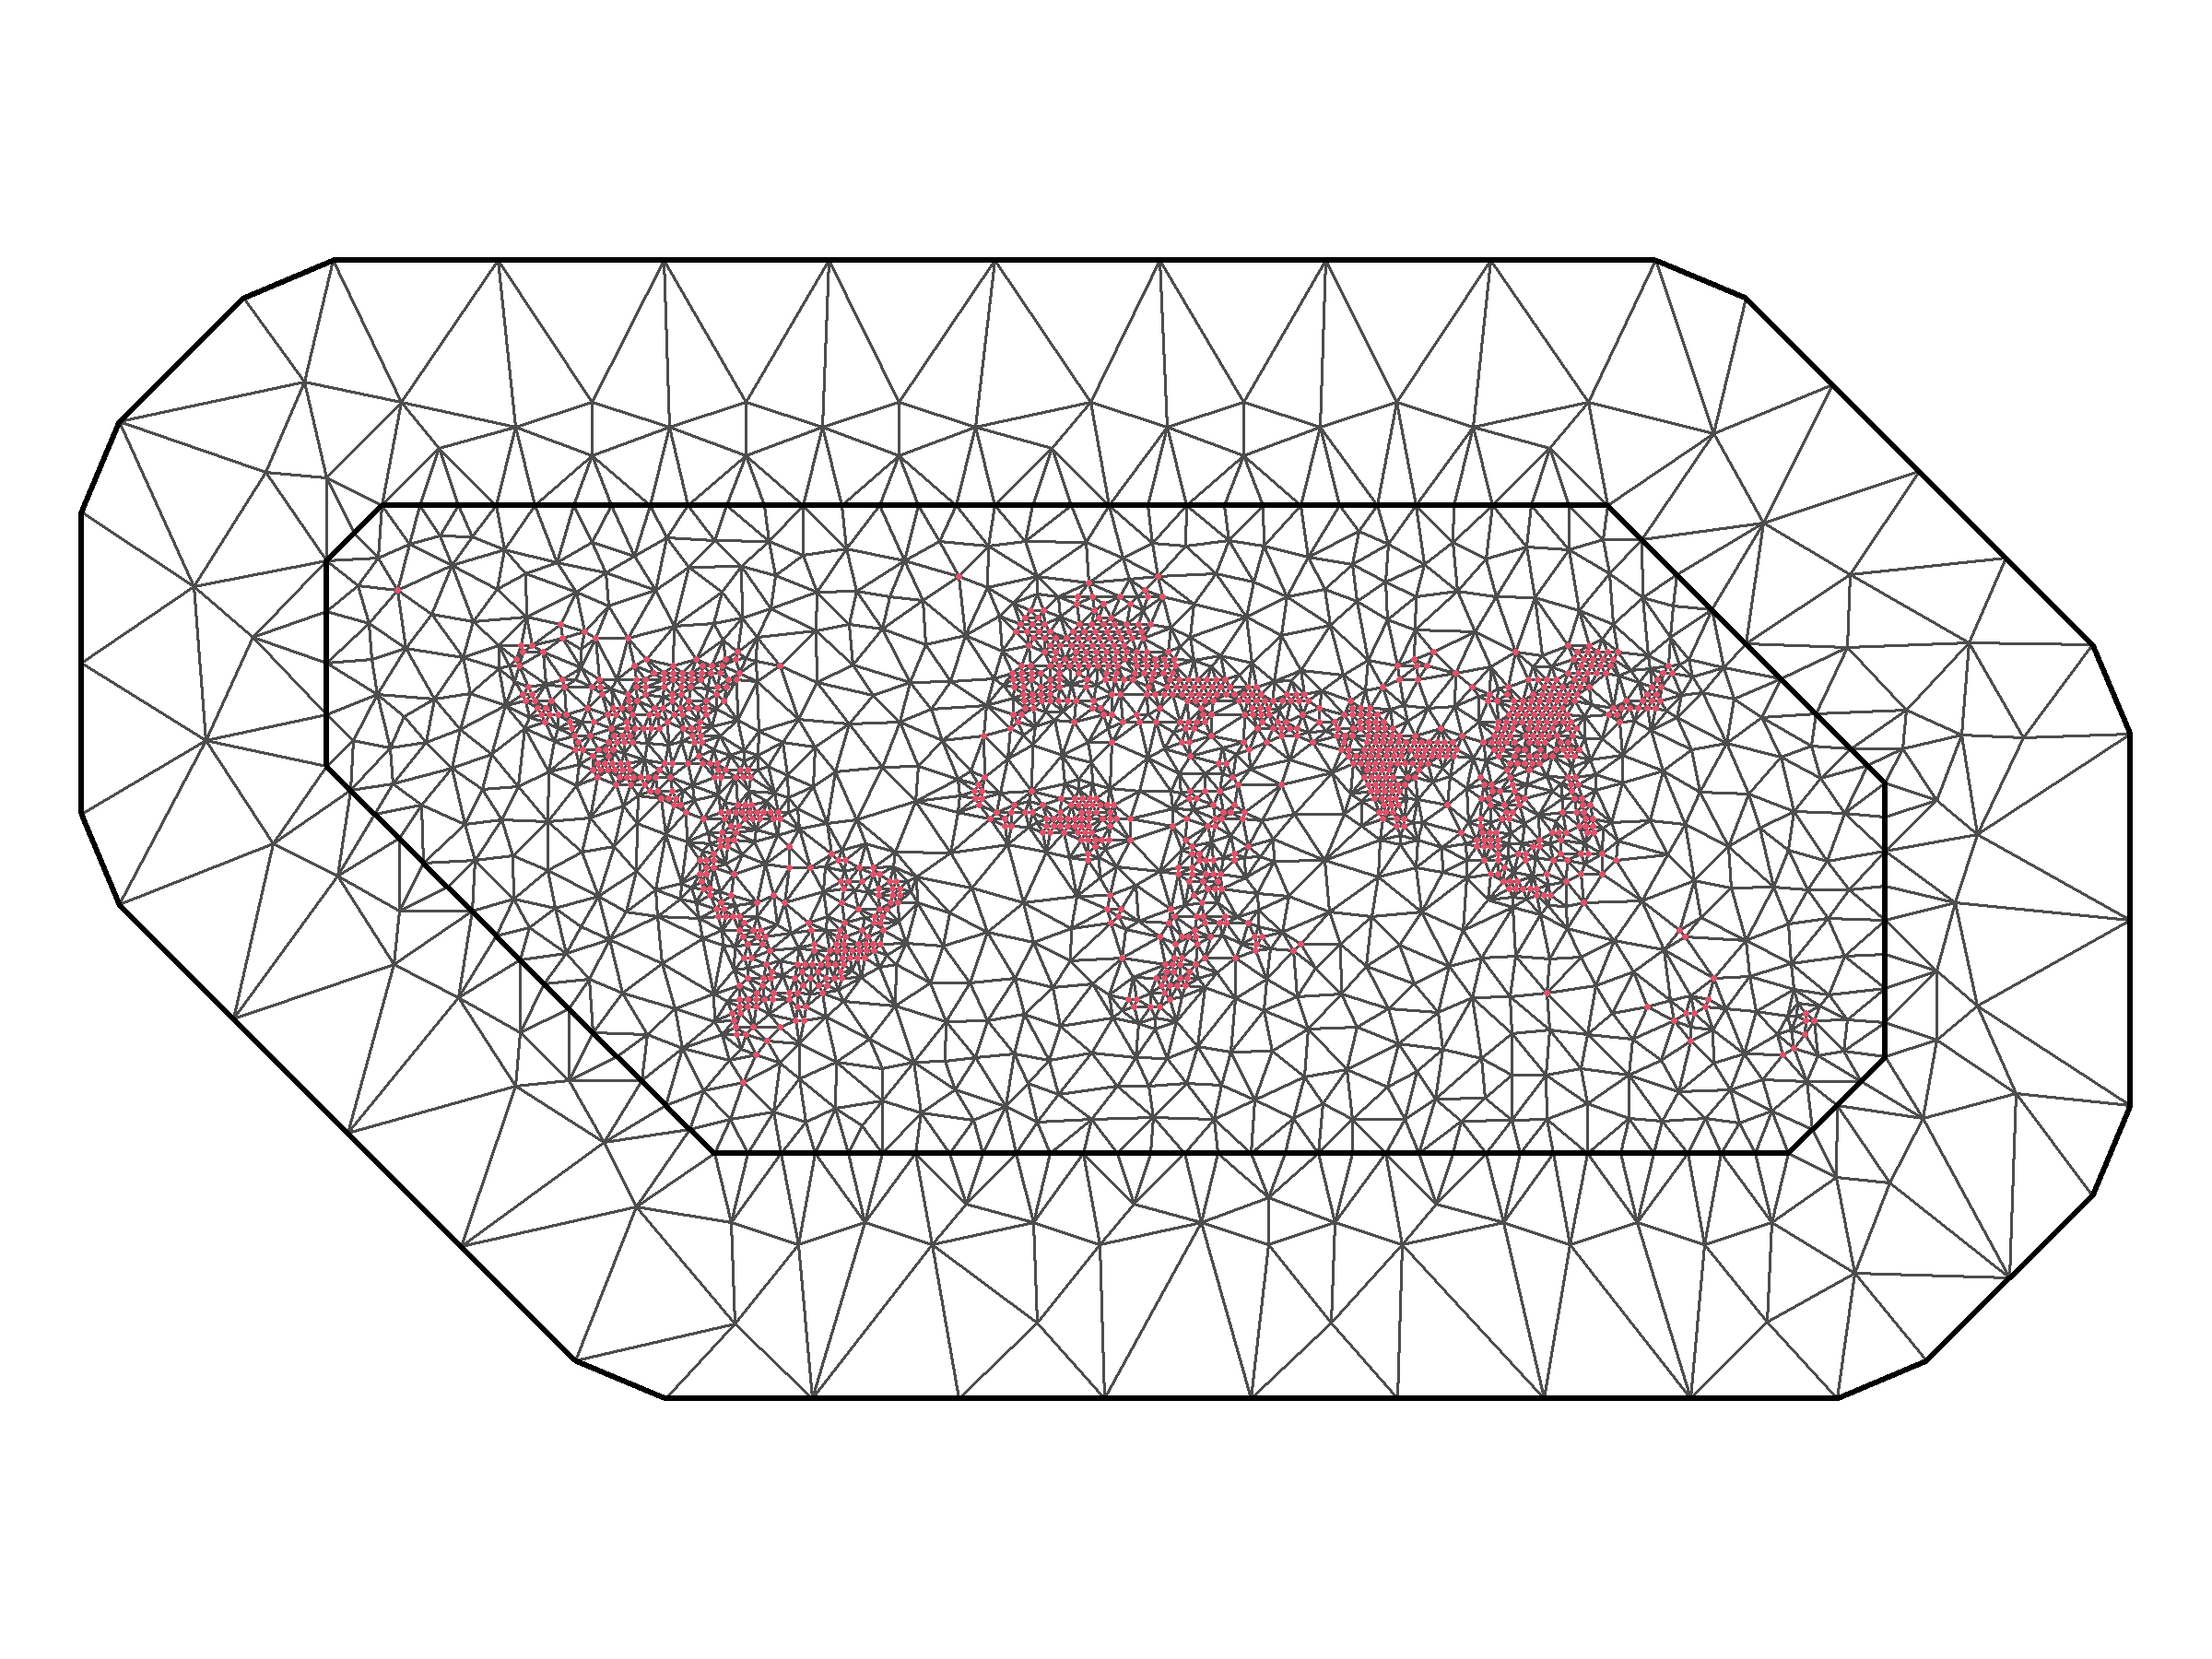

In [8]:
%%R -r 300 -w 8 -h 6 -u in
par(mar=c(0,0,0,0))
df %<>% 
  select_all() %>%
    filter(year >= 1970) %>% # Filter data to only observations beyon 1970
    mutate(long_rads = (long * pi)/180, # Transform to polar coords
           lat_rads = (lat * pi)/180)
Loc = cbind(df$long_rads, df$lat_rads)
Mesh = inla.mesh.2d(Loc, max.edge = c(0.25, 5), cutoff = .001) # Generate a mesh
plot(Mesh,asp = 1, main = "")
points(Loc, col = 2, pch = 16, cex = 0.3)  # Project data onto the mesh

In [9]:
%%R
# Make the projection matrix A
A_point = inla.spde.make.A(Mesh, loc = Loc)
dim(A_point)
# Specify penalized complexity priors
spde.pc = inla.spde2.pcmatern(Mesh,
                              prior.range = c(0.01, 0.01), # probability that the range is less than 0.25 radians is 0.01
                              prior.sigma = c(1, 0.01)) # probability that the variance on the log scale is more than 1 is 0.01

# Make the spatial index
s.index = inla.spde.make.index(name = "w",
                               n.spde = spde.pc$n.spde,
                               n.group = 1,
                               n.repl = 1)
# Specify model formulas
f1 = y~ -1 + Intercept # base intercpt no random effects
f2 = y~ -1 + Intercept + atm_CO2 # Fixed effect no random effects
f3 = y~ -1 + Intercept + atm_CO2 + f(City, model = 'iid') # fixed + random effects for city
f4 = y~ -1 + Intercept + atm_CO2 + f(City, model = 'iid') + f(w, model = spde.pc) # fixed effects + spatial random effects
# Build the stack
N = nrow(df)
stack1 = inla.stack(
  data = list(y = df$AvgTemp_year),
  A = list(1, 1, 1, 1, A_point),
  effects = list(
    Intercept = rep(1,N),
    list(CO2_emissions = df$CO2_emissions, atm_CO2 = df$atm_CO2),
    City = df$City,
    Year = df$year,
    w = s.index
  )
)
model1 = inla(f1,
              family = "gaussian",
              data = inla.stack.data(stack1),
              control.compute = list(dic = T),
              control.predictor = list(A = inla.stack.A(stack1)))
# Print posterior means
round(model1$summary.fixed, 3)

            mean    sd 0.025quant 0.5quant 0.975quant   mode kld
Intercept 13.522 0.029     13.465   13.522     13.579 13.522   0


In [10]:
%%R
model2 = inla(f2,
              family = "gaussian",
              data = inla.stack.data(stack1),
              control.compute = list(dic = T),
              control.predictor = list(A = inla.stack.A(stack1)))
# Print posterior means
model2$summary.fixed

                  mean           sd   0.025quant     0.5quant   0.975quant
Intercept 1.045792e+01 0.5133413188 9.4500655522 1.045790e+01 1.146494e+01
atm_CO2   7.163319e-04 0.0001198257 0.0004810709 7.163291e-04 9.513937e-04
                  mode          kld
Intercept 1.045791e+01 7.262916e-09
atm_CO2   7.163336e-04 7.240827e-09


In [11]:
%%R
model3 = inla(f3,
              family = "gaussian",
              data = inla.stack.data(stack1),
              control.compute = list(dic = T),
              control.predictor = list(A = inla.stack.A(stack1)))
# Print posterior means
model3$summary.fixed

                  mean           sd   0.025quant     0.5quant  0.975quant
Intercept 1.053546e+01 2.074107e-01 1.012823e+01 1.053545e+01 10.94236192
atm_CO2   7.075517e-04 1.961476e-05 6.690412e-04 7.075511e-04  0.00074603
                  mode          kld
Intercept 1.053546e+01 2.773855e-09
atm_CO2   7.075517e-04 4.012346e-10


In [12]:
%%R
model4 = inla(f4,
              family = "gaussian",
              data = inla.stack.data(stack1),
              control.compute = list(dic = T),
              control.predictor = list(A = inla.stack.A(stack1)))
# Print posterior means
model4$summary.fixed

                  mean           sd   0.025quant     0.5quant   0.975quant
Intercept 9.1100194614 3.101686e+00 3.0203631705 9.1099321151 1.519459e+01
atm_CO2   0.0007074095 1.464767e-05 0.0006786512 0.0007074091 7.361438e-04
                  mode          kld
Intercept 9.1100194614 1.615587e-27
atm_CO2   0.0007074095 0.000000e+00


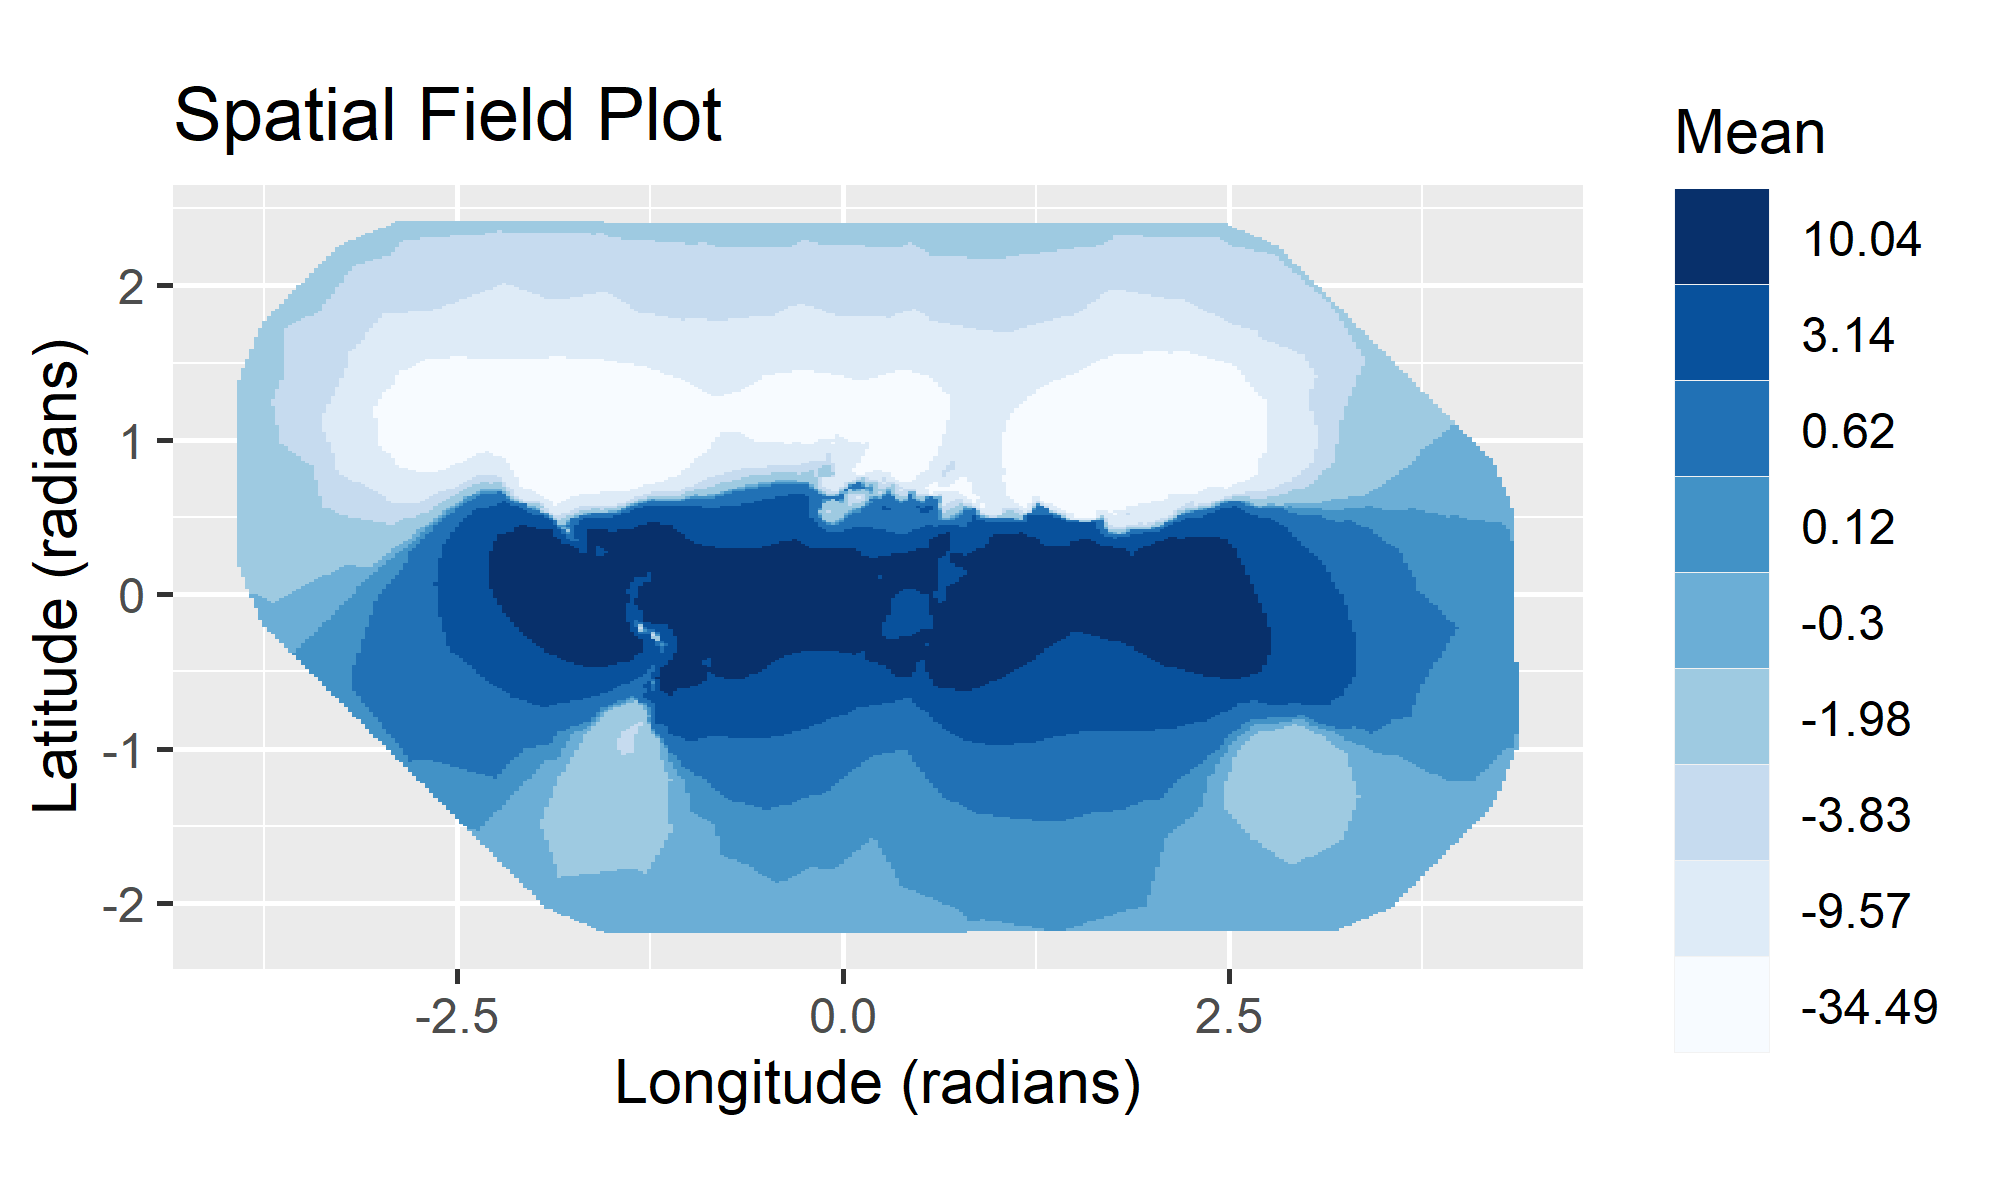

In [13]:
%%R -r 400 -w 5 -h 3 -u in
# Plot the spatial field
ggField(model4, Mesh) + 
  scale_fill_brewer(palette = "Blues") +
  labs(title = "Spatial Field Plot",
       y = "Latitude (radians)",
       x = "Longitude (radians)")

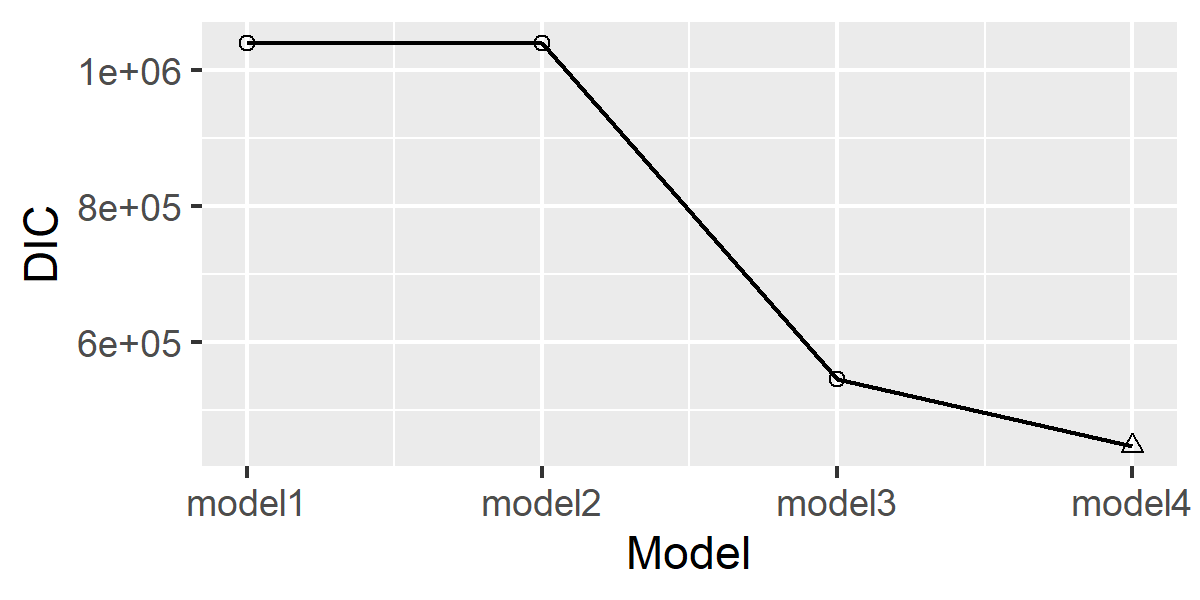

In [14]:
%%R -r 300 -w 4 -h 2 -u in
# Look at model fit using DIC
models = list(model1, model2, model3, model4)
INLADICFig(models,
           ModelNames = c("model1",
                          "model2",
                          "model3",
                          "model4"))

In [15]:
%%R
# New formula (this accounts for spatial random effects and temporal random effects but separately)
f5 = y~ -1 + Intercept + atm_CO2 + f(City, model = 'iid') + f(w, model = spde.pc) + f(Year, model = "ar1") # fixed effects + random effect for city + spatial random effects + temporal random effects for year
model5 = inla(f5,
              family = "gaussian",
              data = inla.stack.data(stack1),
              control.compute = list(dic = T),
              control.predictor = list(A = inla.stack.A(stack1)))
# Print posterior means
model5$summary.fixed

                  mean           sd    0.025quant     0.5quant   0.975quant
Intercept 9.6595602277 7.3465176179 -4.562872e+00 9.5926511916 24.254969777
atm_CO2   0.0006445104 0.0003131209  7.213227e-06 0.0006497916  0.001249801
                  mode          kld
Intercept 9.4605137696 2.365736e-06
atm_CO2   0.0006574611 4.077495e-06


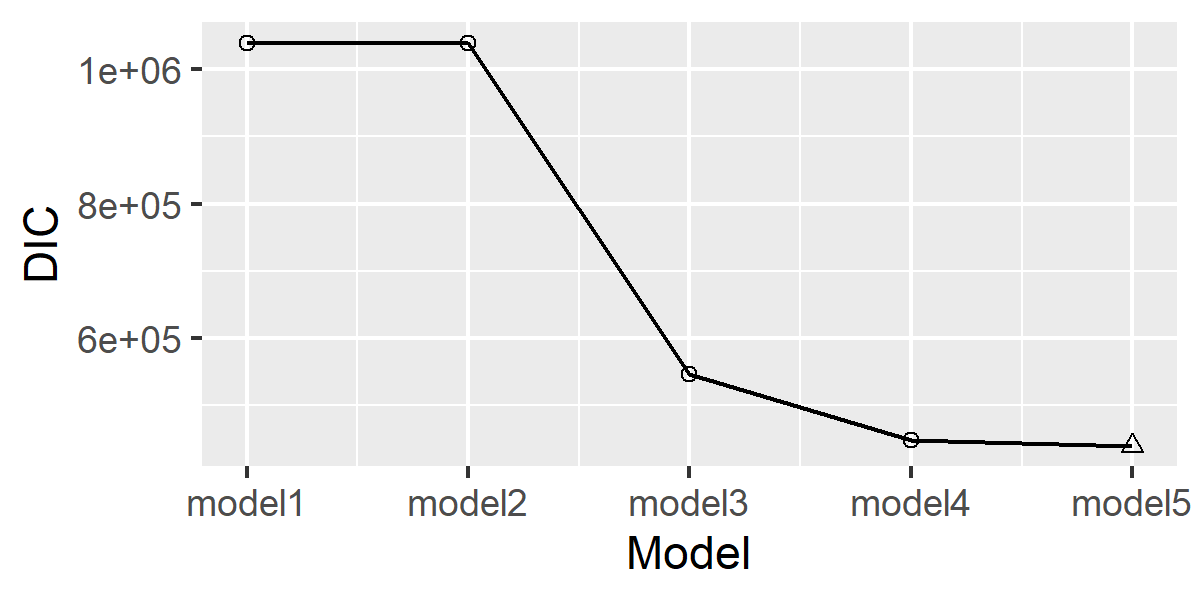

In [16]:
%%R  -r 300 -w 4 -h 2 -u in
models[[5]] = model5
INLADICFig(models,
           ModelNames = c("model1",
                          "model2",
                          "model3",
                          "model4",
                          "model5"))

We can immediately see that there is a large difference between models that do not include random effects (models 1 & 2) and the models that do include random effects (models 3, 4, & 5). Moreover, we can tell from the figure that spatial random effects significantly improve our model fit (model 4) in comparison to only including a random intercept for city (model 3). Ultimately, the best model fit was model 5, which in addition to a random intercept for city and spatial random effects for geographical location includes temporal random effects for year using an autoregressive model of order one (AR1). However, the improvement over model 4 is not as drastic as the improvement between model 4 and model 3, indicating that not a lot of the variation is based on the correlation with time

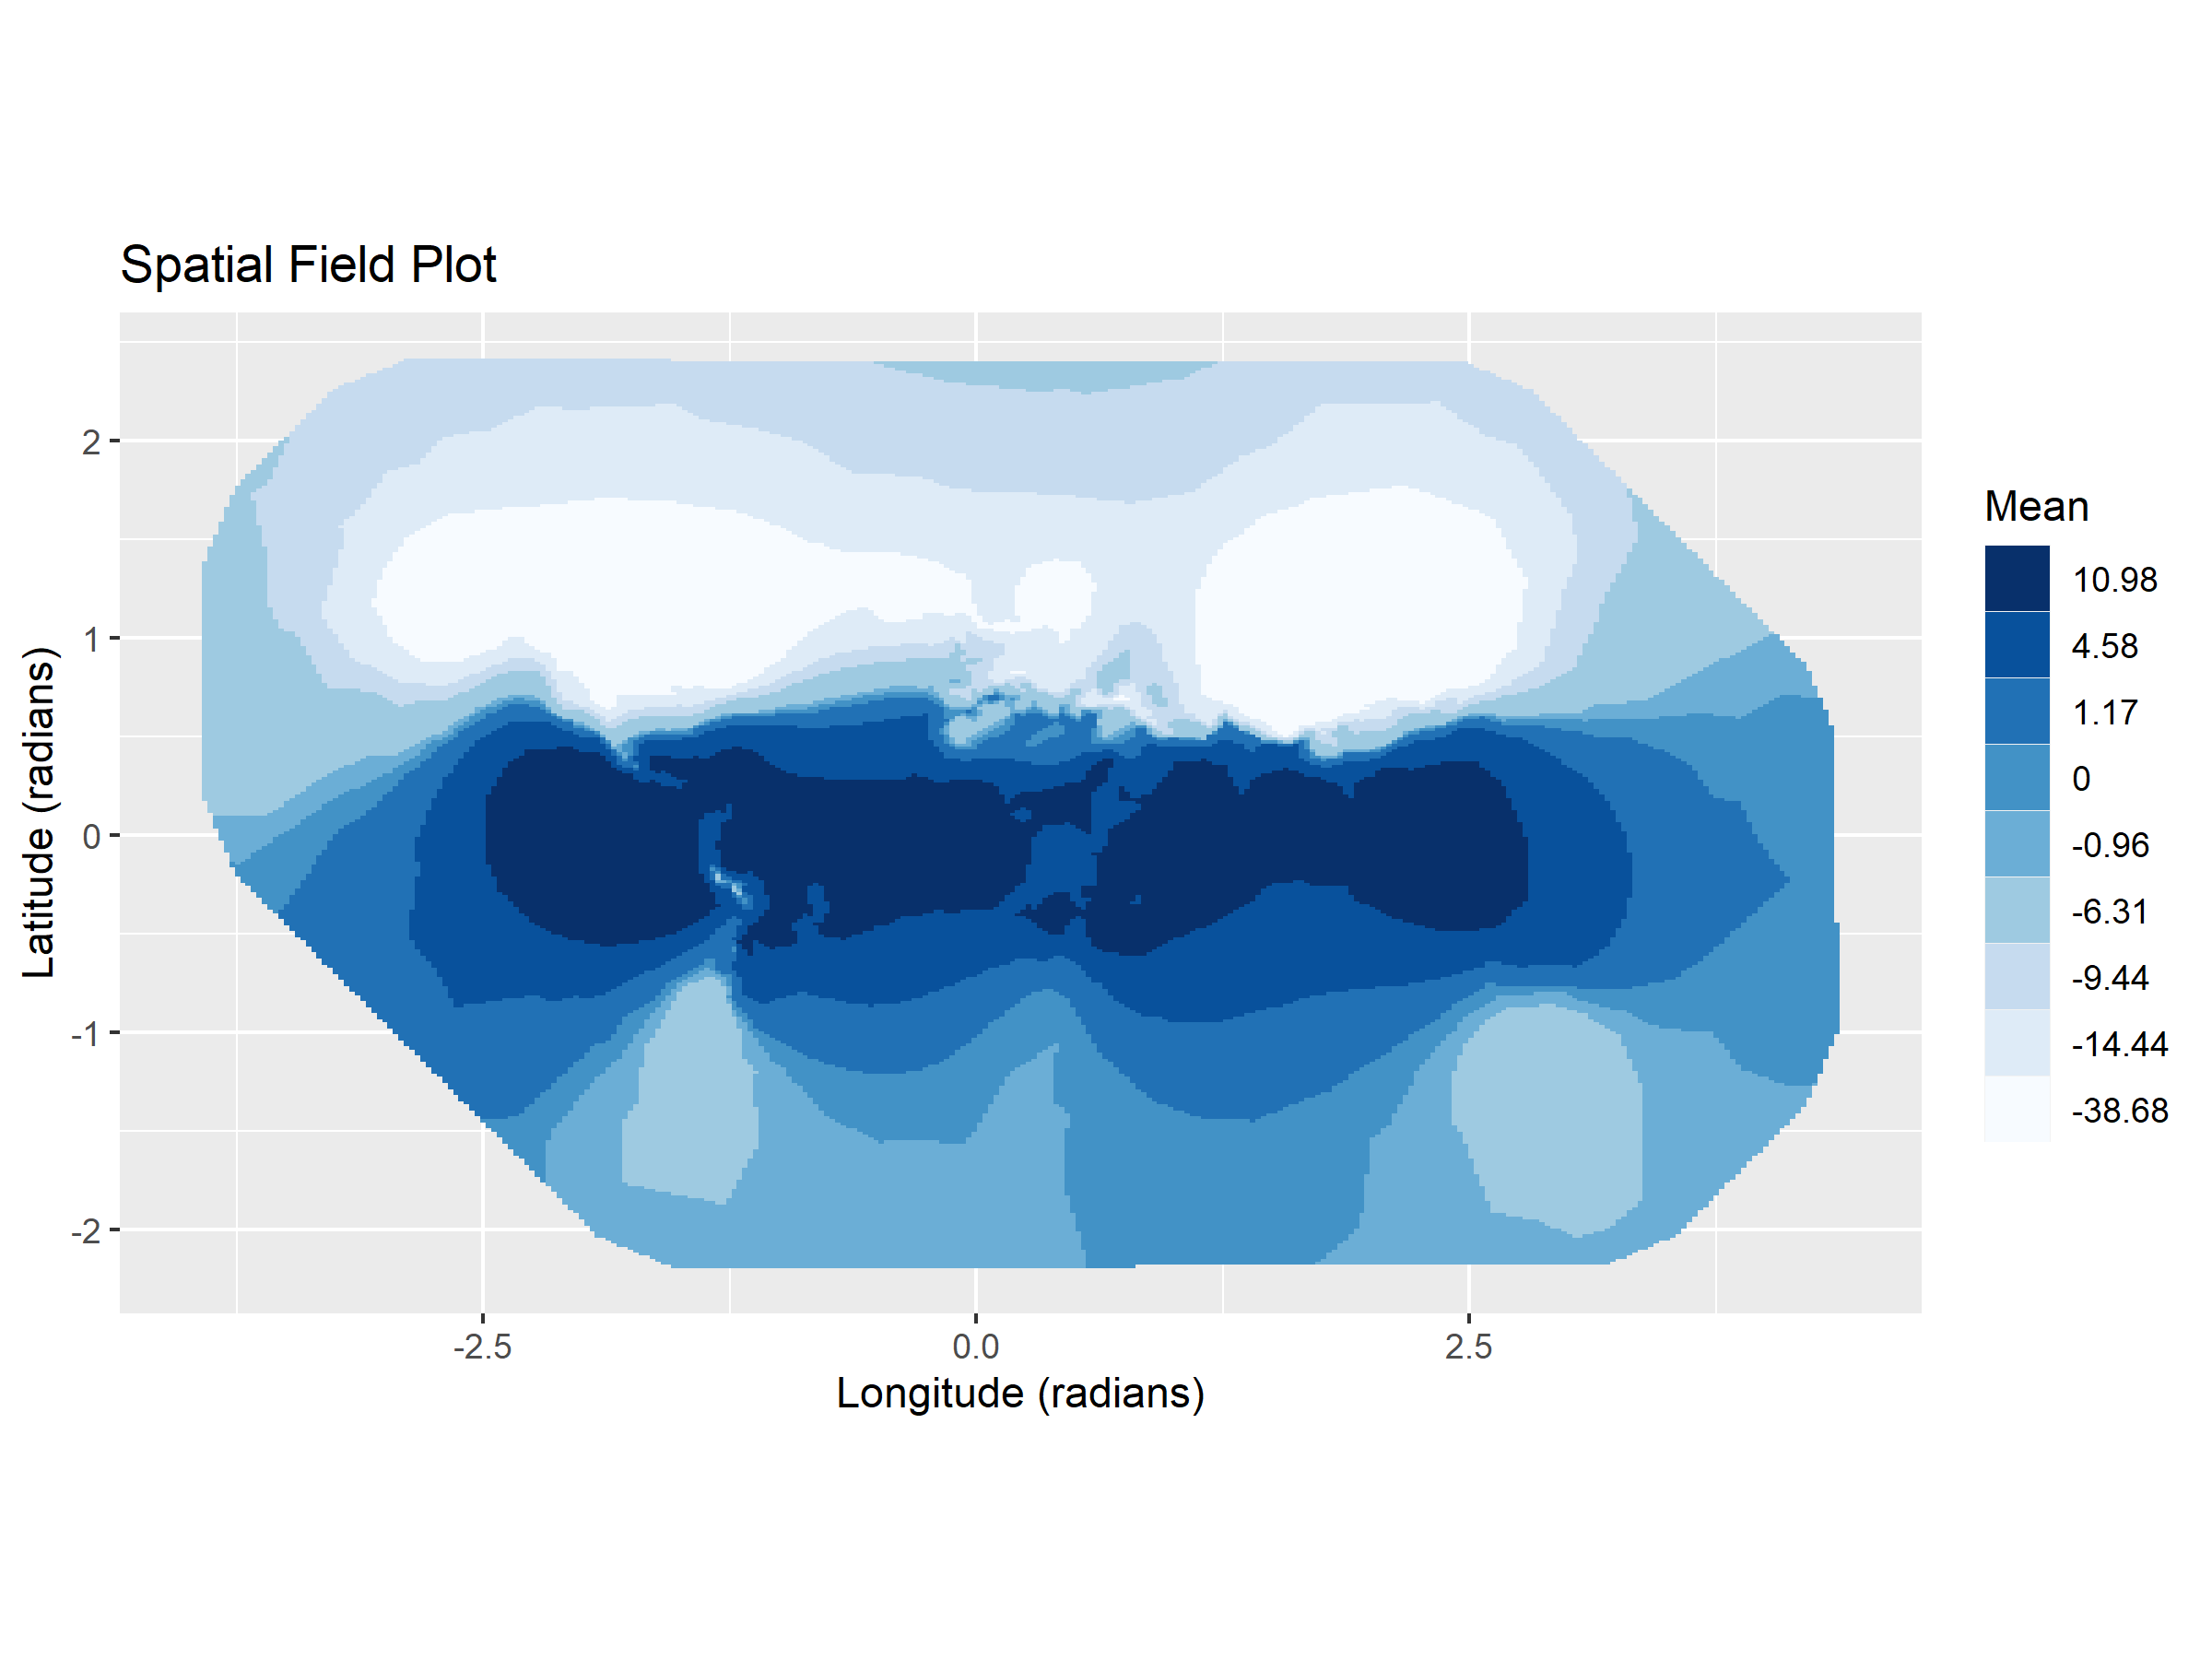

In [17]:
%%R -r 300 -w 8 -h 6 -u in
# Plot the spatial field
ggField(model5, Mesh) + 
  scale_fill_brewer(palette = "Blues") +
  labs(title = "Spatial Field Plot",
       y = "Latitude (radians)",
       x = "Longitude (radians)")

Inspecting model 5, we see that a spatial field plot shows correlated warmer average yearly temperatures around the equator with cooler average yearly temperatures as you move away from landmass and the equator 

In [18]:
%%R
summary(model5)


Call:
   c("inla(formula = f5, family = \"gaussian\", data = 
   inla.stack.data(stack1), ", " control.compute = list(dic = T), 
   control.predictor = list(A = inla.stack.A(stack1)))" ) 
Time used:
    Pre = 2.3, Running = 2894, Post = 6.29, Total = 2902 
Fixed effects:
           mean    sd 0.025quant 0.5quant 0.975quant  mode kld
Intercept 9.660 7.347     -4.563    9.593     24.255 9.461   0
atm_CO2   0.001 0.000      0.000    0.001      0.001 0.001   0

Random effects:
  Name	  Model
    City IID model
   w SPDE2 model
   Year AR1 model

Model hyperparameters:
                                            mean       sd 0.025quant 0.5quant
Precision for the Gaussian observations 6.72e-01 1.70e-02      0.627 6.67e-01
Precision for City                      3.63e+04 2.45e+04   5121.133 3.11e+04
Range for w                             1.14e+00 0.00e+00      1.136 1.14e+00
Stdev for w                             1.62e+01 4.29e-01     15.059 1.60e+01
Precision for Year                    

**The model implies that there is a significant association between Atmospheric CO2 and average yearly temperature. On average, for every ppm increase in Atmospheric CO2 there is a 0.001-degree Celsius increase in average yearly temperature.**